## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from punisher.common import *

import collections
import codecs
from punisher.clients import got3

TWEET_DIR = Path(cfg.DATA_DIR, 'twitter')

In [83]:
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, '__json__'):
            return obj.__json__()
        elif isinstance(obj, collections.Iterable):
            return list(obj)
        elif isinstance(obj, datetime.datetime):
            return obj.isoformat()
        elif hasattr(obj, '__getitem__') and hasattr(obj, 'keys'):
            return dict(obj)
        elif hasattr(obj, '__dict__'):
            return {member: getattr(obj, member)
                    for member in dir(obj)
                    if not member.startswith('_') and
                    not hasattr(getattr(obj, member), '__call__')}

        return json.JSONEncoder.default(self, obj)
    
def plot_price(df, field, asset, ex_id):
    col_name = ohlcv_feed.get_col_name(field, asset.symbol, ex_id)
    punisher.utils.charts.plot_range(
        df, start=None, end=None, 
        column_name=col_name)
    
def get_tweet_query_fpath(query, date):
    query = query.replace(' ', '_')
    query_dir = Path(TWEET_DIR, query)
    query_dir.mkdir(exist_ok=True)
    fname = '{:s}_{:d}_{:d}_{:d}.json'.format(
        query, date.year, date.month, date.day
    )
    return Path(query_dir, fname)

def save_query_tweets(tweets, query, date):
    fpath = get_tweet_query_fpath(query, date)
    f = open(fpath, 'w')
    json.dump(tweets, f, cls=JSONEncoder)
    f.close()

def load_query_tweets(query, date):
    fpath = get_tweet_query_fpath(query, date)
    with codecs.open(fpath, 'r', 'utf-8') as f:
        tweets = json.load(f, encoding='utf-8')
    return tweets

def filter_query_tweets(tweets):
    filtered_tweets = []
    for tweet in tweets:
        if tweet.favorites > 0 or tweet.retweets > 0:
            filtered_tweets.append(tweet)
    return filtered_tweets

def download_tweets(query, start, end, max_daily_tweets, lang):
    """
    query = 'bitcoin OR btc'
    start = datetime.datetime(year=2018, month=2, day=4, hour=0)
    end = datetime.datetime(year=2018, month=2, day=6, hour=0)
    """
    start_str = start.isoformat().split('T')[0]
    end_str = end.isoformat().split('T')[0]
    time_delta = datetime.timedelta(days=1)
    cur_start = start
    tweetCriteria = got3.manager.TweetCriteria().setQuerySearch(
        query).setSince(start_str).setUntil(end_str).setMaxTweets(
        max_tweets).setLang(lang).setTopTweets(True)
    while cur_start < end:
        cur_end = cur_start + time_delta
        print("Start", cur_start, "End", cur_end)
        tweets = got3.manager.TweetManager.getTweets(tweetCriteria)
        tweets = filter_query_tweets(tweets)
        save_query_tweets(tweets, query, cur_start)
        print("Downloaded", len(tweets))
        cur_start = cur_end

## Price

In [61]:
# https://coinmarketcap.com/api/
exchange_ids = [ex_cfg.GDAX]#, ex_cfg.BINANCE]#, ex_cfg.POLONIEX]
symbols = ['BTC/USD']#,'BTC/USDT']
assets = [Asset.from_symbol(sym) for sym in symbols]
start = datetime.datetime(year=2016, month=1, day=1)
timeframe = Timeframe.ONE_HOUR
downloaded_df = ohlcv_feed.load_multiple_assets(
    exchange_ids, assets, timeframe, start, end=None)

In [62]:
columns = ['close_BTC/USD_gdax', 'utc']#,'close_BTC/USDT_binance']
df = downloaded_df.copy()[columns]
#df = df.rename(mapper={columns[i]:exchange_ids[i] for i in range(len(columns)-1)}, axis='columns')
df.tail()

,close_BTC/USD_gdax,utc
epoch,,
1517864400,7078.34,2018-02-05 21:00:00
1517868000,6801.01,2018-02-05 22:00:00
1517871600,6905.19,2018-02-05 23:00:00
1517875200,6975.00,2018-02-06 00:00:00
1517878800,6661.54,2018-02-06 01:00:00


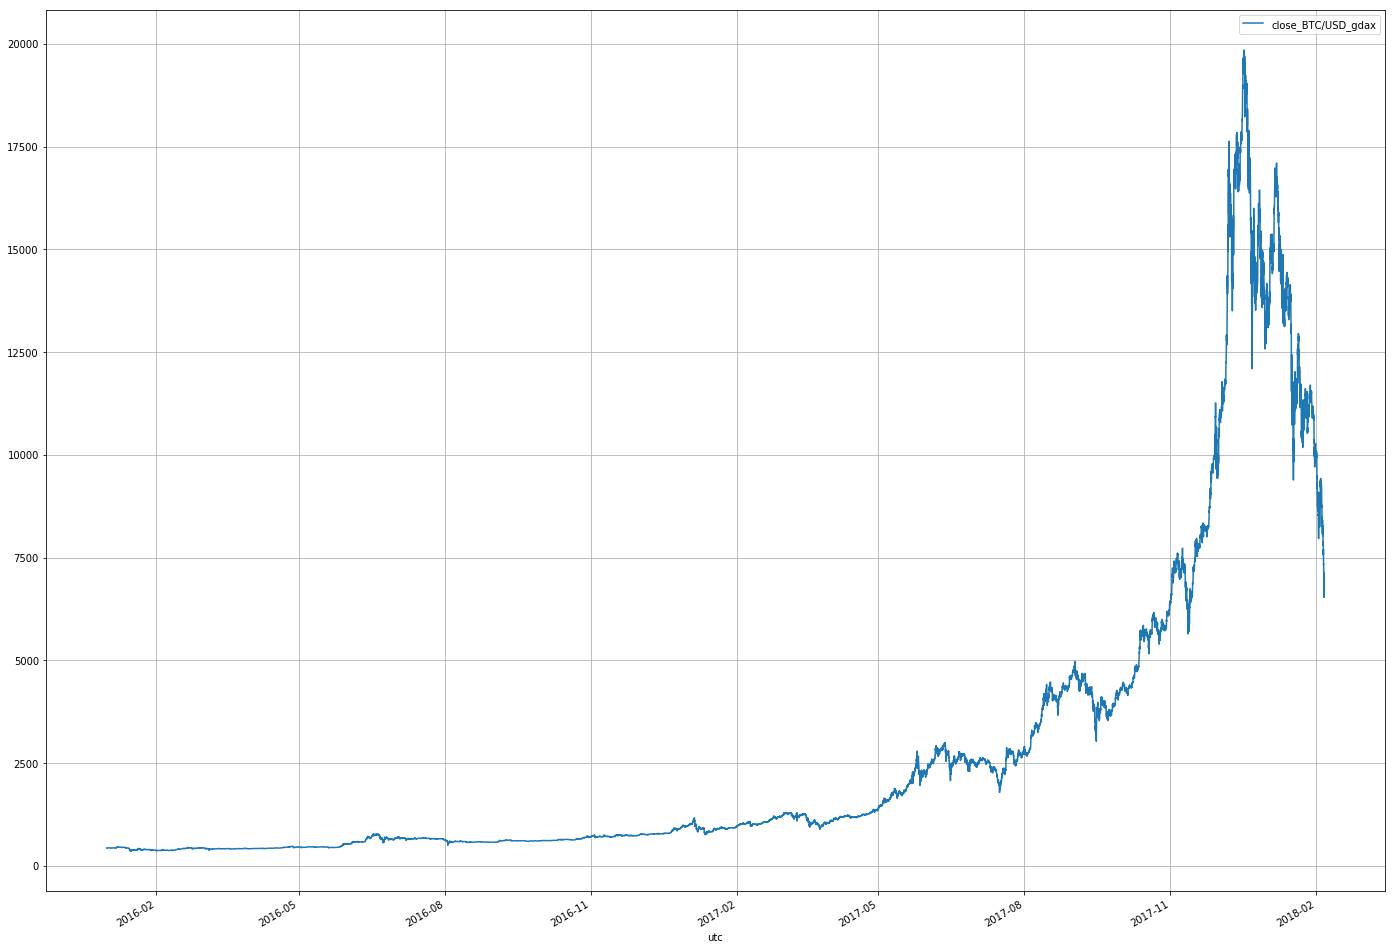

In [63]:
start = datetime.datetime(year=2016, month=1, day=1, hour=0)
end = datetime.datetime(year=2018, month=2, day=6, hour=0)
#times = [datetime(year=2018, month=2, day=1, hour=10, minute=i) for i in range(60)] + [datetime(year=2018, month=2, day=1, hour=11, minute=i) for i in range(60)]
df = df[(df['utc'] > start) & (df['utc'] < end)]
df.plot(x='utc', figsize=(24,18), grid=True)

## Tweets

In [ ]:
# Try out queries: https://twitter.com/search-advanced
# Client: https://github.com/Jefferson-Henrique/GetOldTweets-python/blob/master/got3/manager/TweetManager.py
# Another client, didn't work as well: https://github.com/taspinar/twitterscraper

query = 'bitcoin OR btc'
start = datetime.datetime(year=2016, month=1, day=1, hour=0)
end = datetime.datetime(year=2018, month=2, day=13, hour=0)
max_tweets = 30000
lang = 'en'
%time download_tweets(query, start, end, max_tweets, lang)

Start 2016-01-01 00:00:00 End 2016-01-02 00:00:00


In [ ]:
tweets = load_query_tweets(query, start)

In [ ]:
df = pd.DataFrame(tweets)
df['date'].min(),df['date'].max()

In [ ]:
tweets[:10]